# Example: Query and Plot Materials

### Imports and Token Assignment

In [1]:
import os
import pandas as pd
import seaborn as sns
from pprint import pprint

token = os.environ['EC3_KEY']

### Import EC3Materials and Setup Query

In [2]:
from ec3 import EC3Materials
ec3_materials = EC3Materials(bearer_token=token, ssl_verify=False)

In [3]:
#Conduct a search of normal weights concrete mixes between 2000 psi and 8000 psi within a radius of a given postal code
mat_param_dict =   {
                    "product_classes":{"EC3":"Concrete >> ReadyMix"},
                    "lightweight":False, 
                    "concrete_compressive_strength_at_28d__gt":"2000 psi", 
                    "concrete_compressive_strength_at_28d__lt":"8000 psi", 
                    }

ec3_materials.return_fields = ["id", "concrete_compressive_strength_28d", "gwp"]
ec3_materials.sort_by = "concrete_compressive_strength_28d" #This will sort the responses based on the field assiged to the 'sort_by' property
ec3_materials.only_valid = True
postal_code = 11232

#NOTE The following query may take a few minutes to return all responses
mat_records = ec3_materials.get_materials_within_region(postal_code, plant_distance="10 mi", return_all=True, params=mat_param_dict)

### Clean the Data

In [15]:
#The following code will convert all the compressive strengths to the same units and round to the nearest 500 psi

mpa_to_psi = 145.03773773 #conversion for megapascal

converted_records = []
for rec in mat_records:
    new_dict = {}
    split_strength = rec["concrete_compressive_strength_28d"].split()
    if split_strength[1] == "MPa":
        conc_strength = float(split_strength[0]) * mpa_to_psi
    elif split_strength[1] == "psi":
        conc_strength = float(split_strength[0])
    elif split_strength[1] == "ksi":
        conc_strength = float(split_strength[0]) * 1000
    else:
        continue #unknown unit

    rounded_strength = int(round(conc_strength/ 500.0) * 500.0)

    new_dict["Compressive_Strength"] = rounded_strength
    new_dict["GWP"] = float(rec["gwp"].split()[0])
    converted_records.append(new_dict)

### Create Pandas Dataframe and Plot with Seaborn

In [34]:
df = pd.DataFrame(converted_records)
df.head()

,Compressive_Strength,GWP
0,2000,275.0
1,2000,275.0
2,2000,327.0
3,2000,274.0
4,2000,275.0


In [42]:
#Filter out materials if less than 10 instances of that strength
vc = df.Compressive_Strength.value_counts()
filtered_df = df[df.Compressive_Strength.isin(vc.index[vc.gt(10)])]

Text(0, 0.5, 'GWP [kgCO2e]')

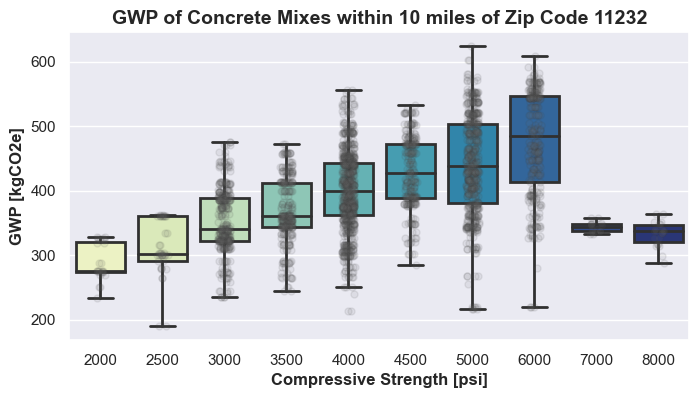

In [43]:
### Create plot with Seaborn ###
sns.set_style("whitegrid") #set style
sns.set(rc={"figure.figsize":(8, 4)}) #set figure size

#Add dots using stripplot
bp = sns.stripplot(data=filtered_df, x='Compressive_Strength', y='GWP', 
                    color="dimgrey", linewidth = 1, alpha=0.1)

#Add boxplot
bp = sns.boxplot(data=filtered_df, x='Compressive_Strength', y='GWP', 
                linewidth = 2, palette="YlGnBu", showfliers = False)

#set axis titles and fonts
bp.set_title("GWP of Concrete Mixes within 10 miles of Zip Code {}".format(postal_code), fontsize = 14, fontweight='bold')
bp.set_xlabel("Compressive Strength [psi]", fontsize = 12, fontweight='bold')
bp.set_ylabel("GWP [kgCO2e]", fontsize = 12, fontweight='bold')